# Faithfulness evaluation of our relation-based explanations

A faithful explanation must agree with the model's prediction. We check how well we can reproduce model predictions based on the relation links.

## Token-to-similarity relations

We will check if the total positives on the right side (predicted label side) exceeds that in the left side (contrast label side).

In [1]:
import os
import json

In [3]:
def summarize(side):
    positives = []
    negatives = []
    for score in side["importance1"] + side["importance2"]:
        if score > 0:
            positives.append(score)
        else:
            negatives.append(score)
            
    return sum(positives), sum(negatives)

In [8]:
def summarize_with_max(side):
    positives = []
    negatives = []
    for score in side["importance1"] + side["importance2"]:
        if score > 0:
            positives.append(score)
        else:
            negatives.append(score)
            
    importance1_positives = [score for score in side["importance1"] if score > 0]
    importance1_negatives = [score for score in side["importance1"] if score < 0]
    importance2_positives = [score for score in side["importance2"] if score > 0]
    importance2_negatives = [score for score in side["importance2"] if score < 0]
            
    return max(sum(importance1_positives), sum(importance2_positives)), \
             max(sum(importance1_negatives), sum(importance2_negatives))

In [9]:
import numpy as np
from scipy.special import softmax

def calculateConfidence(d):
    tau = 15
    distances = np.array(d["distances"][0])
    probs = softmax(distances / 15)
    probs = sorted(probs, reverse=True)
    confidence = probs[0] - probs[1]
    return confidence

In [11]:
from collections import defaultdict


reproductions = {}
confidences = {}

for dataset in ["banking", "hwu", "clinc"]:
    with open(f"../{dataset}-viz_data-12-clusters-label_cluster_chosen_by_majority_in-predicted-label-with-bert.json", "r") as f:
        prediction_info = json.load(f)
    confidences[dataset] = np.array([calculateConfidence(entry) for entry in prediction_info])
    
    with open(f"{dataset}/token2similarity_relations.json") as f:
        tok2sim_relations = json.load(f)

    reproductions[dataset] = defaultdict(list)

    for relation in tok2sim_relations:       
        pos_right_max, neg_right_max = summarize_with_max(relation["right"])
        pos_left_max, neg_left_max = summarize_with_max(relation["left"])
        
        pos_right, neg_right = summarize(relation["right"])
        pos_left, neg_left = summarize(relation["left"])
         
        reproductions[dataset]["total_positive_is_larger_on_right_side"] += [pos_right > pos_left]
        reproductions[dataset]["total_negative_is_smaller_on_right_side"] += [abs(neg_right) < abs(neg_left)]
        reproductions[dataset]["total_of_positives_and_negatives_is_larger_on_right_side"] += [(pos_right + neg_right) > (pos_left + neg_left)]
        reproductions[dataset]["max_positive_sum_is_larger_on_right_side"] += [pos_right_max > pos_left_max]
        reproductions[dataset]["max_negative_sum_is_smaller_on_right_side"] += [abs(neg_right_max) < abs(neg_left_max)]

In [12]:
reproductions["clinc"]

defaultdict(list,
            {'total_positive_is_larger_on_right_side': [True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              False,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              False,
              True,
              True,
              True,
              Fals

In [13]:
results = {}

for dataset in reproductions:
    results[dataset] = defaultdict(list)
    
    for i in range(10):
        threshold = i / 10

        for key, is_reproduced in reproductions[dataset].items():
            is_reproduced = np.array(is_reproduced)

            filtered = is_reproduced[confidences[dataset] > threshold]            
            results[dataset][key].append(filtered.sum() / (confidences[dataset] > threshold).sum())

In [14]:
results

{'banking': defaultdict(list,
             {'total_positive_is_larger_on_right_side': [0.775974025974026,
               0.784906914893617,
               0.7907055630936228,
               0.7968044459881903,
               0.8011303426351113,
               0.8079710144927537,
               0.8123374210330732,
               0.8181468665897732,
               0.826559356136821,
               0.8423127463863338],
              'total_negative_is_smaller_on_right_side': [0.6756493506493506,
               0.6815159574468085,
               0.6862279511533242,
               0.6901701979854116,
               0.6944542564464854,
               0.6985507246376812,
               0.7012263099219621,
               0.7047289504036909,
               0.7086519114688129,
               0.718353044240035],
              'total_of_positives_and_negatives_is_larger_on_right_side': [0.7792207792207793,
               0.7878989361702128,
               0.7937584803256446,
               0.80097

In [109]:
with open("token-to-similarity-faithfulness.json", "w") as f:
    json.dump(results, f)

## Token-to-token relations

We will check if the total strength of the links on the right side (predicted label side) are larger.

In [110]:
import os
import json

In [170]:
def topk(array, k=3):
    return array[array.argsort()][-k:]

In [196]:
reproductions = {}

for dataset in ["banking", "hwu", "clinc"]:
    with open(f"{dataset}/token2token_relations.json") as f:
        tok2tok_relations = json.load(f)
    reproductions[dataset] = defaultdict(list)
    for relation in tok2tok_relations:  
        left_links = np.array(relation["left"]["links"])
        right_links = np.array(relation["right"]["links"])
        
        reproductions[dataset]["total_strength_is_larger_on_right_side"] += [left_links.sum() < right_links.sum()]
        reproductions[dataset]["total_of_top3_is_larger_on_right_side"] += [topk(left_links.flatten()).sum() < topk(right_links.flatten()).sum()]

In [197]:
results = {}

for dataset in reproductions:
    results[dataset] = defaultdict(list)
    
    for i in range(10):
        threshold = i / 10

        for key, is_reproduced in reproductions[dataset].items():
            is_reproduced = np.array(is_reproduced)

            filtered = is_reproduced[confidences[dataset] > threshold]            
            results[dataset][key].append(filtered.sum() / (confidences[dataset] > threshold).sum())

In [198]:
results

{'banking': defaultdict(list,
             {'total_strength_is_larger_on_right_side': [0.602922077922078,
               0.6063829787234043,
               0.6099050203527816,
               0.6109760333449115,
               0.6121511833274461,
               0.6155797101449275,
               0.6157562244518766,
               0.6182237600922722,
               0.6201207243460765,
               0.6307490144546649],
              'total_of_top3_is_larger_on_right_side': [0.8006493506493506,
               0.807845744680851,
               0.8141112618724559,
               0.8211184439041334,
               0.8272695160720593,
               0.8340579710144927,
               0.839836492010405,
               0.8462129950019224,
               0.8527162977867203,
               0.870784056066579]}),
 'hwu': defaultdict(list,
             {'total_strength_is_larger_on_right_side': [0.654275092936803,
               0.65625,
               0.6576923076923077,
               0.655577299

In [199]:
with open("token-to-token-faithfulness.json", "w") as f:
    json.dump(results, f)

In [200]:
import matplotlib.pyplot as plt

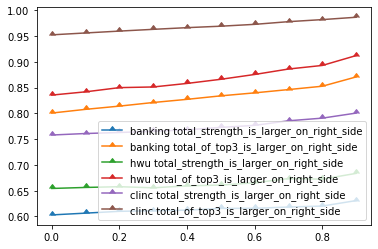

In [217]:
for dataset in ["banking", "hwu", "clinc"]:
    for key, value in results[dataset].items():
        x = np.arange(0,1,0.1)
        y = value
        plt.plot(x, y, marker=10, label=dataset + " " + key)
plt.legend()